# Reproduction of figure 5 

In this notebook we describe how to generate fig 5 from the paper.




The top left and right pannels of the figure consist in synthesizing $N=50000$ glucose molecules in the branching  and elongation regimes (i.e $\Gamma =0.2$ and $\Gamma =10.0$, respectively).

Input parameters for this simulation are available in the [parameters.json] file. 

Here we only have to play with GS and GBE concentrations, as well as $k_{GS}$ and $k_{GBE}$. For $\Gamma = 0.2$  we set `C0 = {"GS":0.2,"GBE":1,"GP":0.0,"GDE":0.0}` and `k = {"k_GS":1,"k_GBE":1,"k_GP":1,"k_GDE":1}` and for $\Gamma = 10.0$ , we set `C0 = {"GS":1.0,"GBE":0.1,"GP":0.0,"GDE":0.0}` and `k = {"k_GS":1,"k_GBE":1,"k_GP":1,"k_GDE":1}`.
  

In [2]:
import numpy as np
import glycogen_module as gm
import json
import random
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

with open("parameters.json", "r") as f:
    parameters = json.load(f)

Altough `glycogen_structure` class from glycogen module contains a Gillespie function, for flexibility purpose we re-defined it here:

In [3]:
def Gillespie_step(structure, C):
    ''' This functions takes concentrations of the enzymes and the structure info of a glycogen granules and
    return what is the next reaction to occurs and which time has been spent. (Following a gillespie algorithm)
    '''
    #propensity assuming mass action kinetics
    h_gs = k["k_GS"]*C["GS"]*len(structure.Find_chain_for_gs())
    h_gp = k["k_GP"]*C["GP"]*len(structure.Find_chain_for_gp())
    h_gbe = k["k_GBE"]*C["GBE"]*len(structure.Find_chain_for_gbe())
    h_gde = k["k_GDE"]*C["GDE"]*len(structure.Find_chain_for_gde())
    
    a = h_gs + h_gp + h_gbe + h_gde
    
    if a == 0:
        return "no reaction can be proceed, all propensities are zero",0
    r2=random.uniform(0,a)    
    r1=random.uniform(0,1)	
    
    d_t = (1/a)*math.log(1/r1)
    if r2 < h_gs :
        return "Act_gs()",d_t
    if r2 >= h_gs and r2 < h_gs + h_gp :
        return "Act_gp()",d_t
    if r2 >=  h_gs + h_gp  and r2 < h_gs + h_gp + h_gbe :
        return "Act_gbe()",d_t
    if r2 >=  h_gs + h_gp + h_gbe  and r2 < h_gs + h_gp + h_gbe + +h_gde:
        return "Act_gde()",d_t   

In what follow perform the simulation, starting by initializing `my_granule` and ask to stop the simulation when $N$ glucose units have been incorporated.  

In the paper we generated $N = 50.000$ units, (average time to perform the simulation is about $2-3$ hours). Here we set $N = 1.000$ as a default value to have short computational time.

The following example serves to produce a structure with $\Gamma = 0.2$

In [4]:
my_granule = gm.glycogen_structure(parameters, 2,1)

parameters['number_max_of_monomer'] = 1000

N = my_granule.number_of_glucose_fixed()  

C0 = {"GS":0.2,"GBE":1,"GP":0.0,"GDE":0.0}          # here set GS = 1.0 and GBE = 0.1 if you want to produce the figure for gamma = 10.0
k = {"k_GS":1,"k_GBE":1,"k_GP":1,"k_GDE":1}  

while N < parameters['number_max_of_monomer']:
    if N%5000 == 0:
        print('avancement = ', 100*N/parameters['number_max_of_monomer'], '%','   part 1/2')
    reaction, time = Gillespie_step(my_granule, C0)

    if reaction == 'Act_gs()':
        my_granule.Act_gs()
    elif reaction == 'Act_gp()':
        my_granule.Act_gp()
    elif reaction == 'Act_gbe()':
        my_granule.Act_gbe_flexible_model()
    elif reaction == 'Act_gde()':
        my_granule.Act_gde()

    N = my_granule.number_of_glucose_fixed()

# write output 
name = 'glycogen_structure_N='+str(N)+'_gamma='+str(C0['GS']/C0['GBE'])+'.json'
my_granule.write_structure( name)  

## Reading the outputs:


<ipython-input-5-4527546199f6>:34: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('test.elongated.png',quality=95)


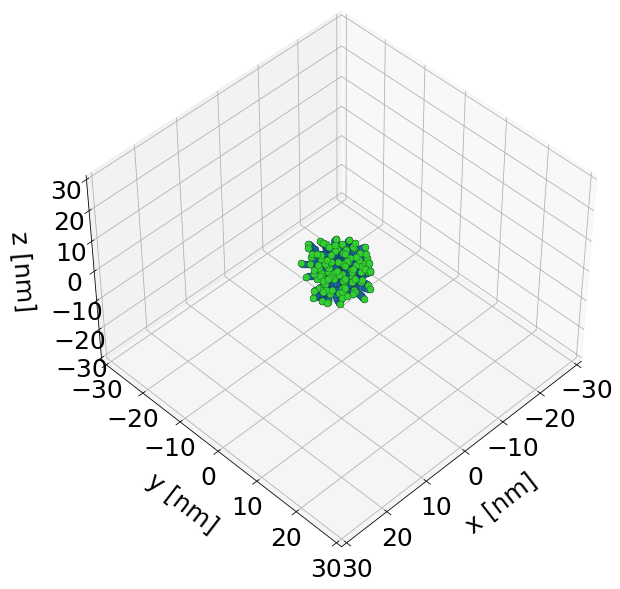

Average degree of polymerisation is:  8.333333333333334
Gyration radius of the granule is :  6.518118434030488 nm


In [5]:
# indicate the pash where the output json file was written
path_file = '/home/yvan/Desktop/paper_reproductibility_github/'+name

with open(path_file, "r") as f:
    my_granule = json.load(f)   
    
# By default these functions are inside the glycogen_structure class. 
# We re-defined here some functions for flexibility

def plot_structure(dict):
    XLIST=[];YLIST=[];ZLIST=[]
    Xnre=[];Ynre=[];Znre=[]
    size = 30
    alpha_segment = []
    for chain in dict.values():
        Xnre.append(0.24*chain['glucose_location'][-1][0])
        Ynre.append(0.24*chain['glucose_location'][-1][1])
        Znre.append(0.24*chain['glucose_location'][-1][2])
        for pos in chain['glucose_location']: 
            XLIST.append(pos[0])
            YLIST.append(pos[1])
            ZLIST.append(pos[2])    

    XLIST,YLIST,ZLIST= 0.24*np.asarray(XLIST),  0.24*np.asarray(YLIST), 0.24* np.asarray(ZLIST)
    ax=plt.figure(figsize=(14,10)).gca(projection='3d')
    ax.view_init(elev=45, azim=45)
    ax.plot(XLIST,YLIST,ZLIST,'o',markersize=7, markeredgewidth=0.2,markeredgecolor='black',label='glycogen 3d')
    ax.plot(Xnre,Ynre,Znre,'o',markersize=7, markeredgewidth=0.2,color='limegreen',markeredgecolor='black',label='glycogen 3d')
    plt.xlabel('x [nm]',fontsize='25', labelpad=20)
    plt.ylabel('y [nm]',fontsize='25', labelpad=20)
    ax.set_zlabel(r'z [nm]',fontsize='25',rotation=200, labelpad=20)
    ax.set(xlim=(-size,size), ylim=(-size, size), zlim = (-size, size))
    plt.tick_params(labelsize=25)
    plt.savefig('test.elongated.png',quality=95)
    plt.show()
    ax.legend()

def number_of_glucose_fixed(dict):
    compteur = 0
    for chain in dict.values():
        compteur= compteur + len(chain['glucose_location'])
    return compteur

def radius3D(dict):
    x,y,z = [],[],[]
    for chain in dict.values(): 
        for pos in chain['glucose_location']:
            x.append(pos[0])
            y.append(pos[1])
            z.append(pos[2])
    N = len(x)
    xmean = 1./N*sum(x)
    ymean = 1./N*sum(y)
    zmean = 1./N*sum(z)
    r2=1.0/N*sum((x-xmean*np.ones(N))**2+(y-ymean*np.ones(N))**2+(z-zmean*np.ones(N))**2)
    return 0.24*r2**0.5,[xmean,ymean,zmean] 

plot_structure(my_granule)



def DPmean(dict):
    dplist = []
    for chain in dict.values(): 
        dplist.append(len(chain['glucose_location']))    
    return np.mean(dplist)

print('Average degree of polymerisation is: ', DPmean(my_granule))
rmean,pos  = radius3D( my_granule)
print('Gyration radius of the granule is : ', rmean , 'nm')  
    

###  Plotting the chain length distribution as histograms

In [6]:
def DP_distribution(dict):
    histo=[]
    for chain in dict.values(): 
        histo.append(len(chain['glucose_location']))
    return histo 

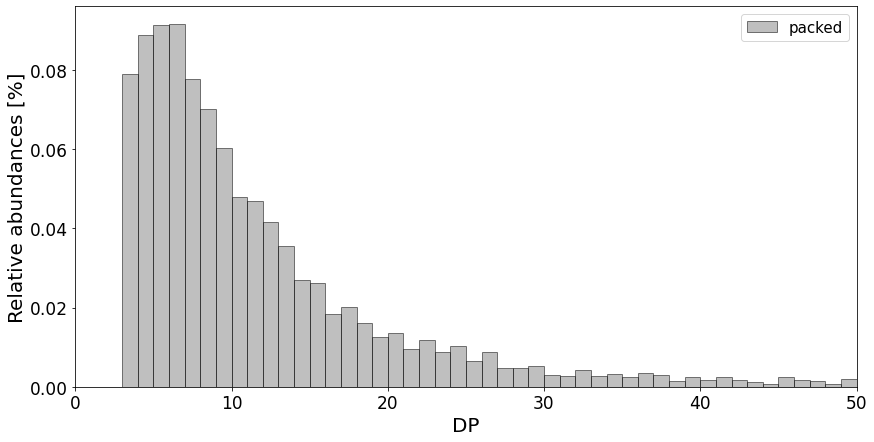

In [8]:
name1 = '/home/yvan/Desktop/reproduction_paper/data_for_tabular/133_0.6/glycogen_structure1.json'
#name2 = '/home/yvan/Desktop/reproduction_paper/data_for_tabular_gamma10/133_10.0/glycogen_structure1.json'

with open(name1, "r") as f:
    my_granule1 = json.load(f)  

#with open(name2, "r") as f:
#    my_granule2 = json.load(f)    
    
Distrib1 = DP_distribution(my_granule1)
#Distrib2 = DP_distribution(my_granule2)

bins1 = np.linspace(0,max(Distrib1), max(Distrib1)+1)
#bins2 = np.linspace(0,max(Distrib2), max(Distrib2)+1)


plt.figure(figsize=(14,7))
plt.hist(Distrib1, bins= bins1, color = 'grey', alpha =0.5, edgecolor = 'black', label = 'packed', density = 1)
#plt.hist(Distrib2, bins= bins2, color = 'black', alpha =0.7, edgecolor = 'black', label = 'elongated', density = 1)
plt.xlabel('DP', fontsize = 20)
plt.ylabel ('Relative abundances [%]', fontsize = 20)
plt.legend(fontsize = 15)
plt.tick_params(axis='both', which='major', labelsize=17)
plt.xlim([0,50])
plt.savefig('fig5c1.png', dpi = 350 )
plt.show()


#plt.figure(figsize=(14,7))
#plt.hist(Distrib2, bins= bins2, color = 'black', alpha =0.7, edgecolor = 'black', label = 'packed', density = 1)
#plt.tick_params(axis='both', which='major', labelsize=35)
#plt.savefig('fig5c2.png', dpi = 350 )
#plt.show()


In [28]:
my_granulebis = gm.glycogen_structure(parameters, 2,1)
my_granulebis.information = my_granule
for chain in my_granulebis.information.values():
    print(chain['generation'])

0
0
1
1
1
1
1
2
1
3
2
2
4
2
2
3
2
3
2
4
2
3
5
2
5
6
2
2
3
2
4
2
1
2
4
2
3
7
2
2
4
3
1
8
3
2
3
2
3
2
4
3
3
2
6
3
4
6
3
5
2
3
3
4
3
2
3
3
4
3
7
4
5
5
1
9
4
5
5
5
8
4
6
2
3
3
5
4
3
4
3
4
3
4
4
6
3
5
2
2
5
6
8
9
8
6
2
3
5
3
3
3
3
3
3
6
4
4
7
10
3
2
10
4
4
2
4
7
4
5
5
5
4
4
6
3
4
5
3
2
3
9
5
7
4
4
7
4
7
4
5
4
4
3
4
7
5
3
3
2
4
3
4
4
4
4
6
5
2
4
5
4
8
3
4
4
5
5
3
8
5
3
7
6
4
3
3
6
4
5
5
8
3
4
6
4
3
4
3
8
4
5
4
3
2
7
3
6
2
9
4
6
2
7
4
4
5
1
4
4
5
4
6
3
8
9
4
5
2
4
4
4
6
8
7
4
3
8
5
4
4
2
3
5
4
4
5
5
2
3
4
4
4
3
4
4
5
5
6
5
6
5
7
6
5
4
5
2
2
4
8
5
2
5
3
3
3
3
4
9
2
5
5
3
4
6
3
4
4
3
4
5
5
3
6
4
4
3
6
5
8
8
4
4
9
7
6
4
5
2
6
6
8
9
4
9
7
5
6
4
10
3
8
4
6
4
5
5
4
4
5
6
7
4
4
2
10
9
4
7
4
5
4
7
7
5
9
5
4
4
4
4
5
5
5
6
8
10
4
9
6
4
9
4
10
5
7
2
4
9
6
5
5
5
3
4
6
5
5
4
4
5
5
4
2
9
5
2
11
4
2
9
6
6
4
5
6
6
6
6
10
6
8
5
7
4
7
8
5
3
6
6
7
5
4
8
4
4
3
8
3
10
6
4
7
4
6
5
2
4
10
5
2
8
5
5
4
6
3
3
4
5
4
8
6
6
5
4
4
4
4
6
6
3
5
5
3
4
7
6
4
4
4
7
10
4
5
2
3
6
6
4
4
5
10
9
6
7
6
10
8
10
10
6
3
5
6
8
5
4
9
6
5